<a href="https://colab.research.google.com/github/ferreret/kaggle-competitions/blob/main/Titanic03_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Titanic - Machine Learning from Disaster</center>

**<center>Notebook 3: XGBoost**

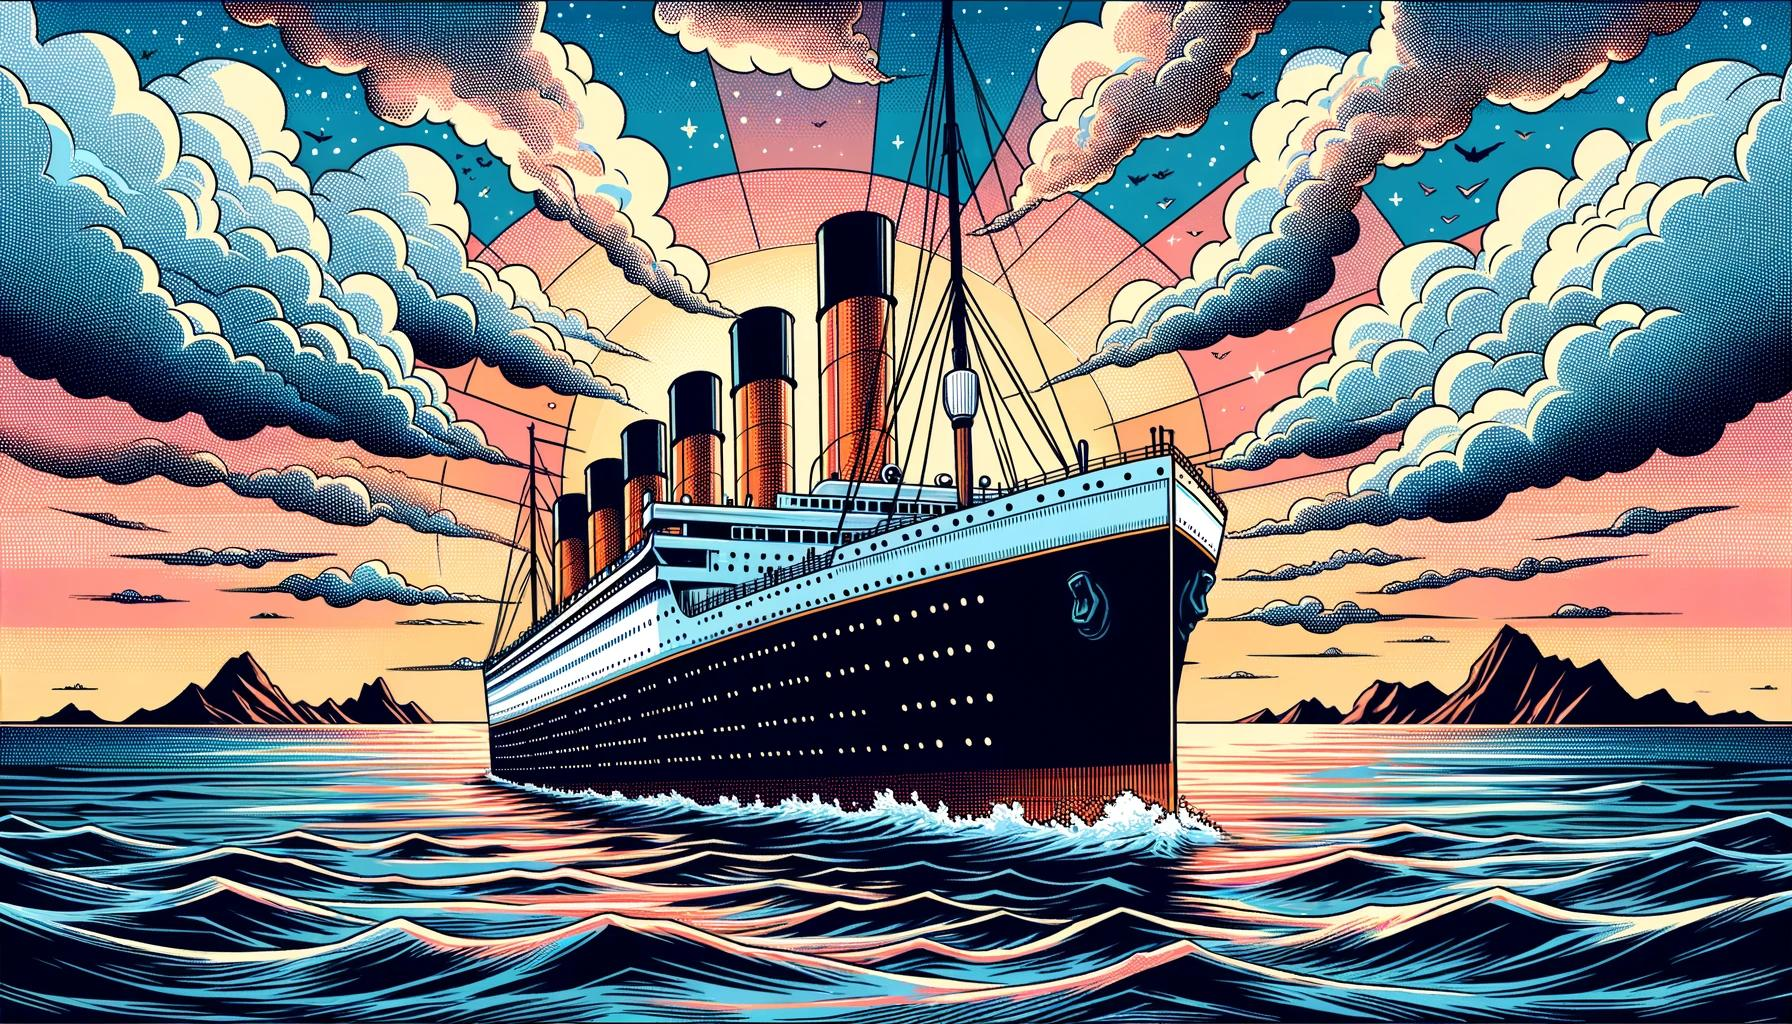

## Note

In this notebook, we will utilize a XGBoost Classifier to predict whether passengers survived or not.

To revisit the Exploratory Data Analysis (EDA) for this dataset, please refer to the notebook titled [Titanic01 - EDA + Logistic Regression](https://www.kaggle.com/code/nicolsbarcel/titanic01-eda-logistic-regression).

## Import libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import XGBoost
import xgboost as xgb

from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

# Show columns without truncate
pd.set_option('display.max_colwidth', None)
# Show all columns
pd.set_option('display.max_columns', None)


## Data Preprocessing

At this point, we're going to import the data and perform some basic preprocessing steps.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load data
train_df = pd.read_csv('/content/drive/MyDrive/Formació/Data Science + Machine Learning/Kaggle/data/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Let's separate the features from the target variable
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

X = train_df[features]
y = train_df['Survived']

### Handling missing values

In [5]:
missing_values_count = X.isnull().sum()
print(missing_values_count)

Pclass      0
Sex         0
Age       177
SibSp       0
Parch       0
Fare        0
dtype: int64


Let's fill the missing values in the `Age` column with the mean age based on `Sex` and `Pclass`.

In [6]:
# Group by Sex and Pclass and calculate the mean of Age
mean_ages = X.groupby(['Sex', 'Pclass'])['Age'].mean()

# Define function to fill missing values for age
def fill_age(row):
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'], row['Pclass']]
    else:
        return row['Age']

X.loc[:, 'Age'] = X.apply(fill_age, axis=1)

/tmp/ipykernel_5698/846034387.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Age'] = X.apply(fill_age, axis=1)


In [7]:
# Check if there are still missing values
missing_values_count = X.isnull().sum()
print(missing_values_count)

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64


Great, no missing values in the `Age` column anymore.

### Handling categorical variables

Let's convert the categorical variables into dummy/indicator variables.

In [8]:
X_encoded = pd.get_dummies(X, columns=['Sex', 'Pclass'], drop_first=True)
X_encoded.head()

,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,1,0,1
1,38.0,1,0,71.2833,0,0,0
2,26.0,0,0,7.9250,0,0,1
3,35.0,1,0,53.1000,0,0,0
4,35.0,0,0,8.0500,1,0,1


## Helper functions

In [9]:
def run_gridsearch(seed, params_grid):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=seed, stratify=y)

    # Create the classifier
    clf = xgb.XGBClassifier(random_state=seed)

    gs = GridSearchCV(clf, params_grid, cv=5, n_jobs=-1)

    # Fit the optimizer
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)

    result = {
        'seed': seed,
        'best_params': gs.best_params_,
        'best_score': gs.best_score_,
        'accuracy': accuracy
    }

    return result

In [10]:
def model_results(predicted, real):

    accuracy = accuracy_score(predicted, real)
    print(f'The accuracy score is: {accuracy * 100:.2f} %\n')

    print(classification_report(real, predicted))

    sns.heatmap(confusion_matrix(real, predicted), annot=True, fmt='g', cmap='Blues');
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show();


In [11]:
def plot_ROC_AUC(model, X_train, X_test, y_train, y_test):
    # Get the probabilities of the positive class for training and testing data
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve for training data
    fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Calculate the ROC curve for test data
    fpr_test, tpr_test, _ = roc_curve(y_test, test_probs)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Set up the figure and axis for the plot, with a specified size
    plt.figure(figsize=(10, 7))

    # Plot the ROC curve for the training data
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')

    # Plot the ROC curve for the testing data
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')

    # Plot a gray dashed line representing random guessing
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    # Set the limits of the x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Label the axes and the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for Random Forest')

    # Add a legend to the plot
    plt.legend(loc='lower right')

    # Add a grid to the plot
    plt.grid(True)

    # Display the plot
    plt.show();

## Modeling with XGBoost

Now, we're going to train a XGBoost Classifier to predict whether passengers survived or not.

We'll try different seeds and perform a grid search to find the best hyperparameters.

In [12]:
warnings.filterwarnings('ignore')

seeds = [0, 1, 42, 50, 123]

results = []

# Define the parameter grid
params_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'lambda': [1, 1.5],
    'alpha': [0, 0.5]
}

for seed in seeds:
    results.append(run_gridsearch(seed, params_grid))

warnings.resetwarnings()

In [13]:
results_df = pd.DataFrame(results)

results_df.sort_values(by='accuracy', ascending=False, inplace=True)

results_df

,seed,best_params,best_score,accuracy
0,0,"{'alpha': 0, 'colsample_bytree': 1.0, 'gamma': 0.2, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}",0.845923,0.843284
3,50,"{'alpha': 0.5, 'colsample_bytree': 1.0, 'gamma': 0, 'lambda': 1.5, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}",0.841084,0.839552
1,1,"{'alpha': 0, 'colsample_bytree': 0.8, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}",0.849187,0.828358
4,123,"{'alpha': 0.5, 'colsample_bytree': 1.0, 'gamma': 0.1, 'lambda': 1, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}",0.852361,0.824627
2,42,"{'alpha': 0, 'colsample_bytree': 1.0, 'gamma': 0, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}",0.844245,0.805970


Let's try with `seed=0` and the parameters we've calculated

## Evaluating the model

In [14]:
best_seed = results_df.iloc[0]['seed']
best_params = results_df.iloc[0]['best_params']

# Let's split train and test data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=best_seed, stratify=y)

# Create the classifier
xgb_clf =xgb.XGBClassifier(random_state=best_seed, **best_params)

# Fit the model
xgb_clf.fit(X_train, y_train)


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1, learning_rate=0.01,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

Now, let's evaluate the model

The accuracy score is: 84.33 %

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       165
           1       0.89      0.68      0.77       103

    accuracy                           0.84       268
   macro avg       0.86      0.81      0.83       268
weighted avg       0.85      0.84      0.84       268



<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


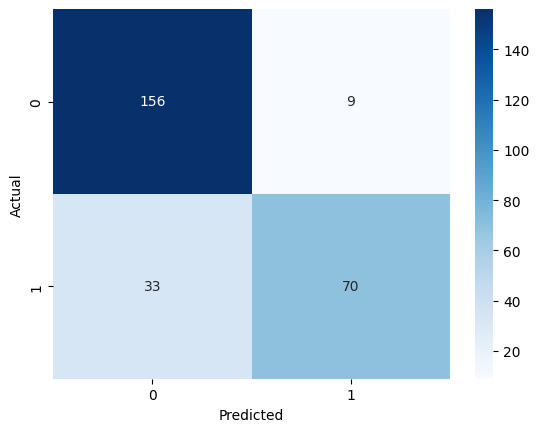

In [15]:
y_pred = xgb_clf.predict(X_test)

model_results(y_pred, y_test)

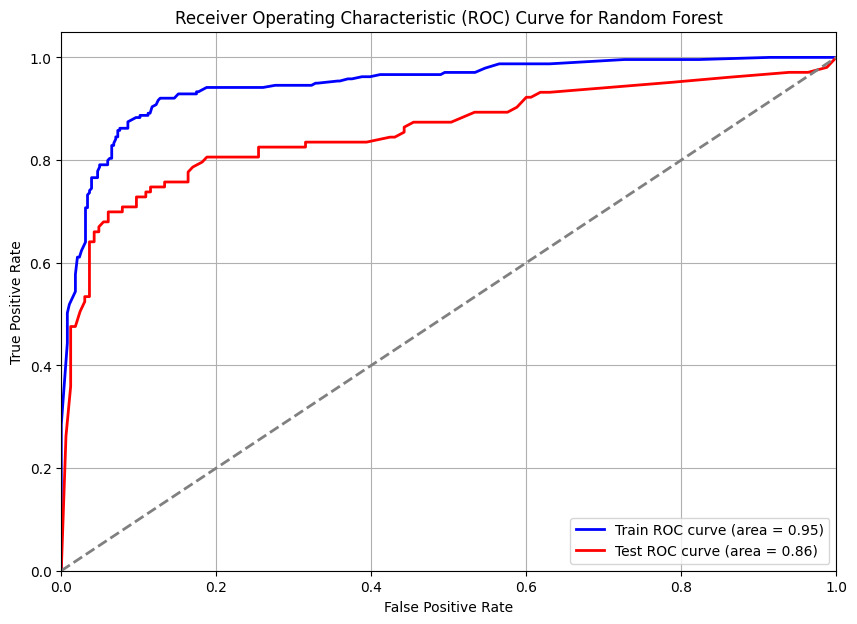

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [16]:
plot_ROC_AUC(xgb_clf, X_train, X_test, y_train, y_test)

There is overfitting, let's improve the hyper-parameters

In [17]:
print(best_params);

{'alpha': 0, 'colsample_bytree': 1.0, 'gamma': 0.2, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}


Let's try to improve the parameters

The accuracy score is: 83.96 %

              precision    recall  f1-score   support

           0       0.81      0.98      0.88       165
           1       0.94      0.62      0.75       103

    accuracy                           0.84       268
   macro avg       0.87      0.80      0.82       268
weighted avg       0.86      0.84      0.83       268



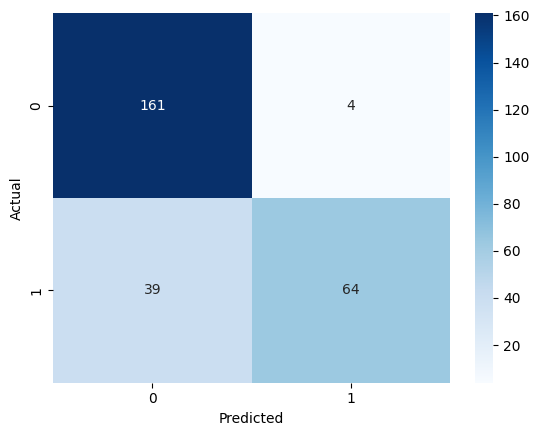

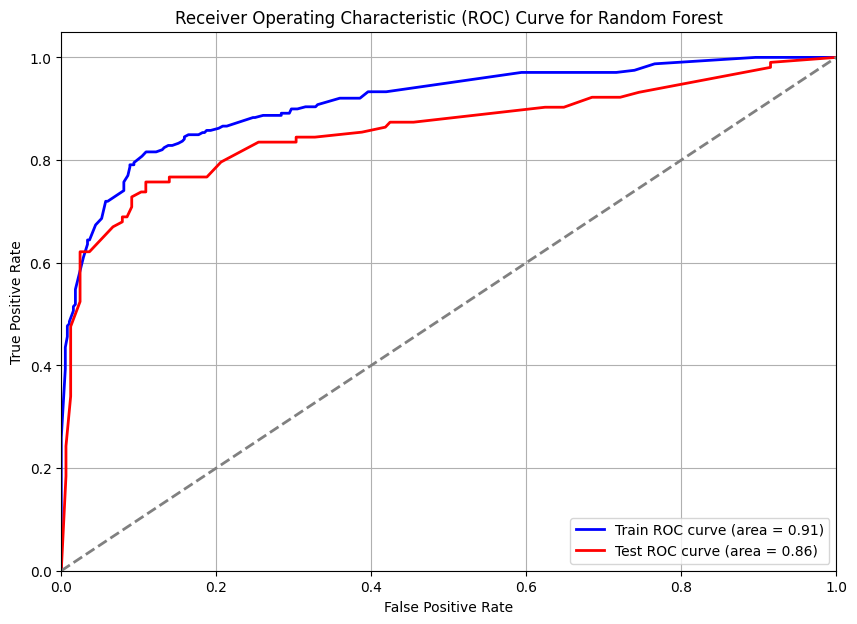

In [18]:
params = {
    'alpha': 0,
    'colsample_bytree': 1.0,
    'gamma': 0.2,
    'lambda': 1,
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'n_estimators': 100, # increase
    'subsample': 1.0
}

# Create the classifier
xgb_clf =xgb.XGBClassifier(
    random_state=best_seed,
    alpha=0.5,
    colsample_bytree=1,
    gamma=0.2,
    learning_rate=0.002, #decrease
    max_depth=4, # decrease
    min_child_weight=1,
    n_estimators=1000, #increase
    subsample=1
)

# Fit the model
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

model_results(y_pred, y_test)
plot_ROC_AUC(xgb_clf, X_train, X_test, y_train, y_test)

There is still a little overfitting, but I think it's good enough for this example.